In [ ]:
!pip uninstall tensorflow
!pip uninstall tensorflow-io
!pip install tensorflow-gpu
!pip install --no-deps tensorflow-io

Found existing installation: tensorflow-io 0.29.0
Uninstalling tensorflow-io-0.29.0:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/tensorflow_io-0.29.0.dist-info/*
    /usr/local/lib/python3.8/dist-packages/tensorflow_io/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-io-0.29.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow_io-0.29.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (26.9 MB)


In [ ]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, KFold

import keras
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate,Dropout
from tensorflow.keras.layers import Multiply, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
import tensorflow
import keras
from sklearn.metrics import confusion_matrix
import cv2
import imgaug.augmenters as iaa
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
!pip install segmentation_models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
focal_loss = sm.losses.cce_dice_loss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
env: SM_FRAMEWORK=tf.keras


In [ ]:
# import keras
# keras.utils.get_custom_objects().u

In [ ]:
import random
import segmentation_models as sm
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c ultrasound-nerve-segmentation

ultrasound-nerve-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip '/content/ultrasound-nerve-segmentation.zip'

Archive:  /content/ultrasound-nerve-segmentation.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test/1.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test/10.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
df=pd.read_csv('/content/train_masks.csv')

In [ ]:
#creating train and test dataframes of images
file_path=pd.DataFrame({'image_path':os.listdir('/content/train')})
file_path_test=pd.DataFrame({'image_path':os.listdir('/content/test')})


In [ ]:
#getting subject and image name from train data
subject=file_path.image_path.apply(lambda x:re.split('_',x)[0])
img_name=file_path_test.image_path.apply(lambda x:x.split('.')[0])
grb=file_path.image_path.apply(lambda x:re.search('_[0-9]+',x).group())
image_name=grb.apply(lambda x:re.split('_',x)[1])

In [ ]:
#adding two columns image name and subject name
file_path['image_name']=image_name
file_path['subject_name']=subject
file_path_test['image_name']=img_name


In [ ]:
#adding file location to file name.
file_path.image_path=file_path.image_path.apply(lambda x:'train/'+x)
file_path_test.image_path=file_path_test.image_path.apply(lambda x:'test/'+x)

In [ ]:
#separating mask images from train images
msk=[i for i in range(len(file_path.image_path)) if 'mask' in file_path.image_path[i]]
img=[i for i in range(len(file_path.image_path)) if 'mask' not in file_path.image_path[i]]
msk=file_path.loc[msk]
img=file_path.loc[img]

In [ ]:
#aligning both to be concatenated later
msk=msk.sort_values(by=['image_name','subject_name'])
img=img.sort_values(by=['image_name','subject_name'])

In [ ]:
#adding mask image path to the df
img['mask_path']=msk.image_path.values

#creating train and test dataframes of images
file_path=pd.DataFrame({'image_path':os.listdir('/content/train')})
file_path_test=pd.DataFrame({'image_path':os.listdir('/content/test')})
#getting subject and image name from train data
subject=file_path.image_path.apply(lambda x:re.split('_',x)[0])
img_name=file_path_test.image_path.apply(lambda x:x.split('.')[0])
grb=file_path.image_path.apply(lambda x:re.search('_[0-9]+',x).group())
image_name=grb.apply(lambda x:re.split('_',x)[1])

#adding two columns image name and subject name
file_path['image_name']=image_name
file_path['subject_name']=subject
file_path_test['image_name']=img_name

#adding file location to file name.
file_path.image_path=file_path.image_path.apply(lambda x:'train/'+x)
file_path_test.image_path=file_path_test.image_path.apply(lambda x:'test/'+x)

#separating mask images from train images
msk=[i for i in range(len(file_path.image_path)) if 'mask' in file_path.image_path[i]]
img=[i for i in range(len(file_path.image_path)) if 'mask' not in file_path.image_path[i]]
msk=file_path.loc[msk]
img=file_path.loc[img]

#aligning both to be concatenated later
msk=msk.sort_values(by=['image_name','subject_name'])
img=img.sort_values(by=['image_name','subject_name'])

#adding mask image path to the df
img['mask_path']=msk.image_path.values
img.head()

,image_path,image_name,subject_name,mask_path
9757,train/1_1.tif,1,1,train/1_1_mask.tif
3391,train/10_1.tif,1,10,train/10_1_mask.tif
7010,train/11_1.tif,1,11,train/11_1_mask.tif
703,train/12_1.tif,1,12,train/12_1_mask.tif
5115,train/13_1.tif,1,13,train/13_1_mask.tif


In [ ]:
import random
import segmentation_models as sm
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
#creating an array that will store all images in 64*64 resized format
X1 = np.zeros((len(img), 64, 64), dtype=np.float32)
for i in range(len(img)):
  img1=cv2.imread(img.image_path.iloc[i],cv2.IMREAD_GRAYSCALE)
  img1=cv2.resize(img1, (64,64))
  X1[i]=img1

In [ ]:
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim

In [ ]:

#finding similarity between resized images and storing it in a dictionary
# sim=dict()
# for i in tqdm(range(len(X1))):
#   for j in range(len(X1)):
#       if i!=j:
#         if tuple(sorted((i,j))) not in sim.keys():
#           simil=ssim(X1[i],X1[j])
#           if abs(simil)>0.99:
#             sim[tuple(sorted((i,j)))]=simil

In [ ]:
# import pickle

# # Open a file and use dump()
# with open('/content/drive/MyDrive/sim.pkl', 'wb') as file:
	
# 	# A new file will be created
# 	pickle.dump(sim, file)


In [ ]:
import pickle

# Open a file and use dump()
with open('/content/drive/MyDrive/sim.pkl', 'rb') as file:
	
	# A new file will be created
	sim = pickle.load(file)
 
print(sim)

{(5, 240): 0.9937457333089711, (5, 1598): 0.9937660224202879, (5, 2162): 0.9937460976238881, (5, 2914): 0.9937508053063133, (12, 2404): 0.9953462459480141, (12, 3485): 0.9999915191992429, (12, 4143): 0.9984038387077535, (12, 5600): 0.9999915191992429, (17, 3819): 0.997319406180566, (20, 114): 0.99999982035869, (20, 1472): 0.9985942732183701, (20, 3305): 1.0, (20, 3634): 0.9985849092723073, (23, 3120): 0.9990419046944864, (25, 119): 0.998071767942905, (25, 2746): 0.9980701673336067, (35, 5529): 0.9969300485261369, (41, 5441): 0.9988499015547468, (51, 521): 0.9990088124737185, (51, 3101): 0.9990097501384361, (51, 3712): 0.9984258149861646, (51, 4323): 0.9983518239092977, (95, 3803): 0.9983132388688518, (95, 4461): 1.0, (95, 4884): 0.9983191129518111, (102, 4233): 0.9999611746447109, (111, 1939): 0.997674316953345, (114, 1472): 0.9985944401632203, (114, 3305): 0.99999982035869, (114, 3634): 0.9985850813866453, (118, 1993): 0.9954621167325106, (118, 3356): 0.9955871664707113, (118, 5236): 

In [ ]:
#storing conflicting images' keys in a list if their similarity is >0.99 in their resized form
conf=[]
for i in tqdm(sim.keys()):
  if sim[i]>0.99:
    msk1=cv2.imread(img.mask_path.iloc[i[0]],cv2.IMREAD_GRAYSCALE)
    msk2=cv2.imread(img.mask_path.iloc[i[1]],cv2.IMREAD_GRAYSCALE)
    if msk1.any()!=msk2.any():
      conf.append(i)

100%|██████████| 1063/1063 [00:02<00:00, 373.20it/s]


In [ ]:
#out of conflicting image pair dropping the image that doesn't contains a mask
indices=[img.iloc[i[1]].name if cv2.imread(img.mask_path.iloc[i[0]],
                                           cv2.IMREAD_GRAYSCALE).any()==True else img.iloc[i[0]].name for i in conf]
indices=list(set(indices))
img.drop(indices,axis=0,inplace=True)

In [ ]:
img

,image_path,image_name,subject_name,mask_path
9757,train/1_1.tif,1,1,train/1_1_mask.tif
3391,train/10_1.tif,1,10,train/10_1_mask.tif
7010,train/11_1.tif,1,11,train/11_1_mask.tif
703,train/12_1.tif,1,12,train/12_1_mask.tif
5115,train/13_1.tif,1,13,train/13_1_mask.tif
...,...,...,...,...
8993,train/47_99.tif,99,47,train/47_99_mask.tif
4050,train/5_99.tif,99,5,train/5_99_mask.tif
1998,train/7_99.tif,99,7,train/7_99_mask.tif
6587,train/8_99.tif,99,8,train/8_99_mask.tif


In [ ]:
im_height=128
im_width=128

In [ ]:
import tensorflow_io as tfio
def cnn_generator(images, maskname, is_training, batch_size=64):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename,maskname):
        #reading path 
        image_string = tf.io.read_file(filename)
        #decoding image
        image = tfio.experimental.image.decode_tiff(image_string)

        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        
        image = tf.image.resize(image, [im_height, im_width])
        
        mask=tf.io.read_file(maskname)
        mask=tfio.experimental.image.decode_tiff(mask)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        mask = tf.image.resize(mask, [im_height, im_width],method='nearest')
        return image,mask
    
    def flip_lr(image,labels):
        
        image = tf.image.flip_left_right(image)
        labels = tf.image.flip_left_right(labels)
        
        return image,labels
    def flip_ud(image,labels):
        
        image = tf.image.flip_up_down(image)
        labels = tf.image.flip_up_down(image)
        
        return image,labels    
    
    def rotate(image,labels):
        val=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        return tf.image.rot90(image, val),tf.image.rot90(labels,val)
    
    
    dataset = tf.data.Dataset.from_tensor_slices((images,maskname))
    
    if is_training:
        dataset = dataset.shuffle(5000)  # depends on sample size
        
    # Transform and batch data at the same time
    dataset = dataset.apply(tf.data.experimental.map_and_batch( parse_function, batch_size,num_parallel_batches=4,  # cpu cores
        drop_remainder=True if is_training else False))
    # augmentations = [flip,rotate]
    
    if is_training:   
      if np.random.uniform(0,1)<0.2:
          dataset = dataset.map(flip_lr)
      elif np.random.uniform(0,1)<0.4:
          dataset = dataset.map(flip_ud)
      elif np.random.uniform(0,1)<0.5:        
          dataset = dataset.map(rotate)
    dataset = dataset.repeat()
    
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset



In [ ]:
from sklearn.model_selection import train_test_split
X_train_new,X_valid,y_train_new,y_valid=train_test_split(img.image_path,img.mask_path,test_size=0.2,random_state=42)
tr_cnn_generator = cnn_generator(X_train_new,y_train_new, is_training=True, batch_size=64)
val_cnn_generator = cnn_generator(X_valid,y_valid, is_training=False, batch_size=64)

Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [ ]:
from datetime import datetime
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True,write_grads=True)
callbacks = [
    ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=False),
    tensorboard_callback]

In [ ]:
def atrous_block(input):
  '''Implement DAC block as given in paper'''
  q1=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr0',dilation_rate=1,activation='relu')(input)
  q2=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr1',dilation_rate=2,activation='relu')(input)
  q2=Conv2D(filters=512,kernel_size=(1,1),padding='same',strides=1,name='atr2',dilation_rate=1,activation='relu')(q2)
  q3=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr3',dilation_rate=1,activation='relu')(input)
  q3=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr4',dilation_rate=2,activation='relu')(q3)
  q3=Conv2D(filters=512,kernel_size=(1,1),padding='same',strides=1,name='atr5',dilation_rate=1,activation='relu')(q3)
  q4=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr6',dilation_rate=1,activation='relu')(input)
  q4=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr7',dilation_rate=2,activation='relu')(q4)
  q4=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr8',dilation_rate=4,activation='relu')(q4)
  q4=Conv2D(filters=512,kernel_size=(1,1),padding='same',strides=1,name='atr9',dilation_rate=1,activation='relu')(q4)
  atr_out=concatenate([q1,q2,q3,q4],axis=-1)
  print(atr_out.shape)
  return atr_out


In [ ]:
def rmp_block(input):
  '''Implement RMP block as given in paper'''
  X1=MaxPooling2D((2,2),strides=(2,2))(input)
  X1=Conv2DTranspose(512,(2,2),padding='same',activation='relu',strides=(2,2))(X1)
  X2=MaxPooling2D((3,3),strides=(2,2),padding='same')(input)
  X2=Conv2DTranspose(512,(3,3),padding='same',activation='relu',strides=(2,2))(X2)
  X3=MaxPooling2D((5,5),strides=(2,2),padding='same')(input)
  X3=Conv2DTranspose(512,(5,5),padding='same',activation='relu',strides=(2,2))(X3)
  X4=MaxPooling2D((6,6),strides=(2,2),padding='same')(input)
  X4=Conv2DTranspose(512,(6,6),padding='same',activation='relu',strides=(2,2))(X4)
  concat=concatenate([X1,X2,X3,X4],axis=-1)
  return concat


In [ ]:
def convolutional_block(input, filters=3, kernel_size=3, batchnorm = True):
    #conv layer followed by batchnormalization
    x = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same')(input)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same')(input)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    return x

In [ ]:
def resunet_opt(input_img, filters = 64, dropout = 0.2, batchnorm = True):
    """Residual Unet + Dense Atrous convolution + Rmp block"""
    conv1 = convolutional_block(input_img, filters * 1, kernel_size = 3, batchnorm = batchnorm)
    pool1 = MaxPooling2D((2, 2))(conv1)
    drop1 = Dropout(dropout)(pool1)

    conv2 = convolutional_block(drop1, filters * 2, kernel_size = 3, batchnorm = batchnorm)
    pool2 = MaxPooling2D((2, 2))(conv2)
    drop2 = Dropout(dropout)(pool2)

    conv3 = convolutional_block(drop2, filters * 4, kernel_size = 3, batchnorm = batchnorm)
    pool3 = MaxPooling2D((2, 2))(conv3)
    drop3 = Dropout(dropout)(pool3)

    conv4 = convolutional_block(drop3, filters * 8, kernel_size = 3, batchnorm = batchnorm)
    pool4 = MaxPooling2D((2, 2))(conv4)
    drop4 = Dropout(dropout)(pool4)

    conv5 = convolutional_block(drop4, filters = filters * 16, kernel_size = 3, batchnorm = batchnorm)
    #atrous conv or dillated conv is when filter has holes in it.
    conv5=atrous_block(conv5)
    conv5 = convolutional_block(conv5, filters = filters * 16, kernel_size = 3, batchnorm = batchnorm)
    conv5=rmp_block(conv5)
    conv5 = convolutional_block(conv5, filters = filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    ups6 = Conv2DTranspose(filters * 8, (3, 3), strides = (2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv5)
    ups6 = concatenate([ups6, conv4])
    ups6 = Dropout(dropout)(ups6)
    conv6 = convolutional_block(ups6, filters * 8, kernel_size = 3, batchnorm = batchnorm)

    ups7 = Conv2DTranspose(filters * 4, (3, 3), strides = (2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv6)
    ups7 = concatenate([ups7, conv3])
    ups7 = Dropout(dropout)(ups7)
    conv7 = convolutional_block(ups7, filters * 4, kernel_size = 3, batchnorm = batchnorm)

    ups8 = Conv2DTranspose(filters * 2, (3, 3), strides = (2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv7)
    ups8 = concatenate([ups8, conv2])
    ups8 = Dropout(dropout)(ups8)
    conv8 = convolutional_block(ups8, filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    ups9 = Conv2DTranspose(filters * 1, (3, 3), strides = (2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv8)
    ups9 = concatenate([ups9, conv1])
    ups9 = Dropout(dropout)(ups9)
    conv9 = convolutional_block(ups9, filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(4, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
im_height=128
im_width=128
input_img = Input((im_height, im_width,4), name='img')
model = resunet_opt(input_img, filters=16, dropout=0.4, batchnorm=True)
model.compile(optimizer=Adam(learning_rate=1e-5), loss=focal_loss, metrics=[iou_score])

(None, 8, 8, 2048)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  592         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 128, 128, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

In [ ]:
sample=next(iter(tr_cnn_generator))

In [ ]:
sample[1].shape

TensorShape([64, 128, 128, 4])

In [ ]:
result_clf=model.fit(tr_cnn_generator,steps_per_epoch=64,epochs=30,validation_data=val_cnn_generator,
                                                               validation_steps=64,callbacks=callbacks)

Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 1.2927 - iou_score: 0.3283
Epoch 1: val_loss improved from inf to 1.18127, saving model to best_model.h5
64/64 [==============================] - 93s 927ms/step - loss: 1.2927 - iou_score: 0.3283 - val_loss: 1.1813 - val_iou_score: 0.1191
Epoch 2/30
64/64 [==============================] - ETA: 0s - loss: 1.2881 - iou_score: 0.3294
Epoch 2: val_loss improved from 1.18127 to 1.17224, saving model to best_model.h5
64/64 [==============================] - 61s 960ms/step - loss: 1.2881 - iou_score: 0.3294 - val_loss: 1.1722 - val_iou_score: 0.1236
Epoch 3/30
64/64 [==============================] - ETA: 0s - loss: 1.2825 - iou_score: 0.3313
Epoch 3: val_loss improved from 1.17224 to 1.15434, saving model to best_model.h5
64/64 [==============================] - 76s 1s/step - loss: 1.2825 - iou_score: 0.3313 - val_loss: 1.1543 - val_iou_score: 0.1324
Epoch 4/30
64/64 [==============================] - ETA: 0s - loss: 1.2744

In [ ]:
model.save('/content/drive/MyDrive/model')

In [ ]:
#loading the classifier model
tf.keras.models.load_model('/content/drive/MyDrive/classifier_nerve',custom_objects={'categorical_crossentropy_plus_dice_loss':focal_loss,'iou_score':iou_score})
#model_clf.compile(optimizer=Adam(learning_rate=1e-5), loss=focal_loss, metrics=[iou_score])

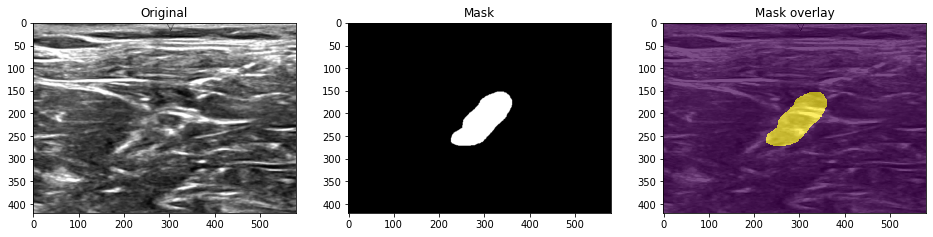

In [ ]:
img_arr=np.array(Image.open(img.iloc[5].image_path))
image1_mask = np.array(Image.open(img.iloc[5].mask_path))
fig, ax = plt.subplots(1,3,figsize = (16,12))
ax[0].imshow(img_arr, cmap = 'gray')
ax[0].set_title('Original')

ax[1].imshow(image1_mask, cmap = 'gray')
ax[1].set_title('Mask')
ax[2].imshow(img_arr, cmap = 'gray', interpolation = 'none')
ax[2].imshow(image1_mask, interpolation = 'none', alpha = 0.7)
ax[2].set_title('Mask overlay')
plt.show()

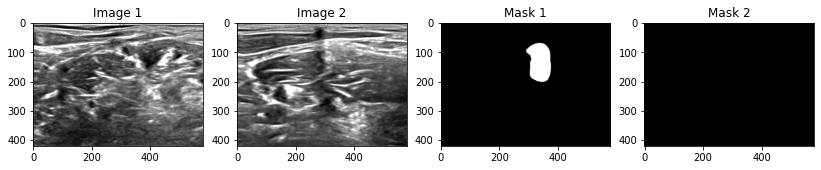

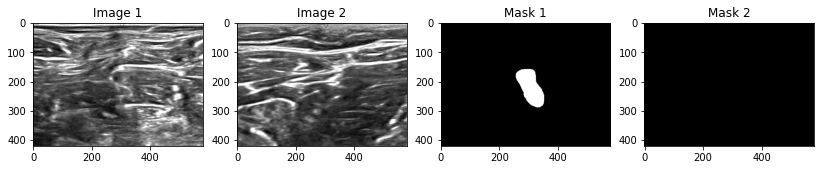

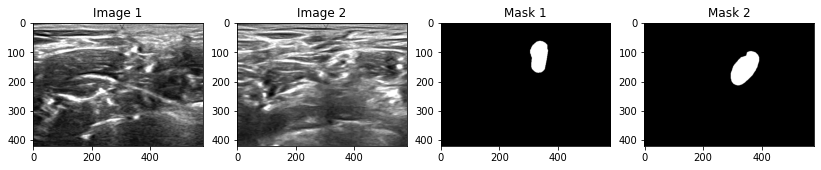

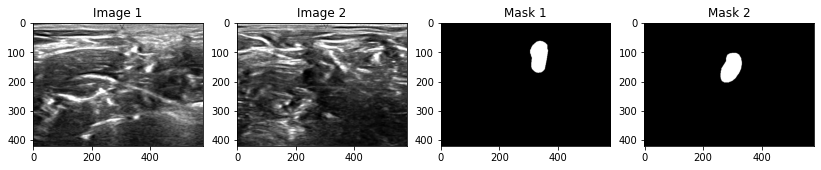

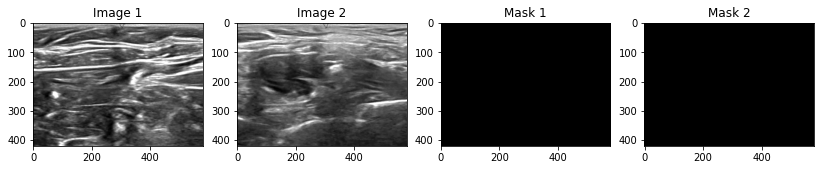

In [ ]:
#plotting few of the conflicting image and mask pairs
cnt=0
for i in conf:
  fig,ax=plt.subplots(1,4,figsize=(14,7))
  cnt+=1
  img1=cv2.imread(img.image_path.iloc[i[0]],cv2.IMREAD_GRAYSCALE)
  ax[0].imshow(img1,cmap='gray')
  ax[0].set_title('Image 1')
  img2=cv2.imread(img.image_path.iloc[i[1]],cv2.IMREAD_GRAYSCALE)
  ax[1].imshow(img2,cmap='gray')
  ax[1].set_title('Image 2')
  msk1=cv2.imread(img.mask_path.iloc[i[0]],cv2.IMREAD_GRAYSCALE)
  ax[2].imshow(msk1,cmap='gray')
  ax[2].set_title('Mask 1')
  msk2=cv2.imread(img.mask_path.iloc[i[1]],cv2.IMREAD_GRAYSCALE)
  ax[3].imshow(msk2,cmap='gray')
  ax[3].set_title('Mask 2')
  if cnt==5:
    break


In [ ]:
#out of conflicting image pair dropping the image that doesn't contains a mask
indices=[img.iloc[i[1]].name if cv2.imread(img.mask_path.iloc[i[0]],
                                           cv2.IMREAD_GRAYSCALE).any()==True else img.iloc[i[0]].name for i in conf]
indices=list(set(indices))
img.drop(indices,axis=0,inplace=True)

In [ ]:
img.to_csv('dup_rem.csv')

In [ ]:
#classifier

In [ ]:
df=pd.read_csv('/content/train_masks.csv')
img=pd.read_csv('/content/dup_rem.csv')

In [ ]:
img.drop('Unnamed: 0',axis=1,inplace=True)
img.image_name=img.image_name.astype(int)
img.subject_name=img.subject_name.astype(int)
img.columns=['image_path','img','subject','mask_path']
new_df=pd.merge(img,df,on=['img','subject'])
new_df.pixels.fillna(0,inplace=True)
val=[0 if i==0 else 1 for i in new_df.pixels]
new_df['mask_pres']=val

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(new_df.image_path, new_df.mask_pres, test_size=0.2, random_state=42)

In [ ]:
def cnn_generator1(images, labels, is_training, batch_size=64):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename,labels):
        #reading path 
        image_string = tf.io.read_file(filename)
        #decoding image
        image = tfio.experimental.image.decode_tiff(image_string)

        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        
        image = tf.image.resize(image, [im_height, im_width])
        return image,labels
    
    def flip_lr(image,labels):
        
        image = tf.image.flip_left_right(image)
        
        return image,labels
    def flip_ud(image,labels):
        
        image = tf.image.flip_up_down(image)
        
        return image,labels    
    
    def rotate(image,labels):
        val=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        return tf.image.rot90(image, val),labels
    
    
    dataset = tf.data.Dataset.from_tensor_slices((images,labels))
    
    if is_training:
        dataset = dataset.shuffle(5000)  # depends on sample size
        
    # Transform and batch data at the same time
    dataset = dataset.apply(tf.data.experimental.map_and_batch( parse_function, batch_size,num_parallel_batches=4,  # cpu cores
        drop_remainder=True if is_training else False))
    # augmentations = [flip,rotate]
    
    if is_training:   
      if np.random.uniform(0,1)<0.1:
          dataset = dataset.map(flip_lr)
      elif np.random.uniform(0,1)<0.2:
          dataset = dataset.map(flip_ud)
      elif np.random.uniform(0,1)<0.3:        
          dataset = dataset.map(rotate)
    dataset = dataset.repeat()
    
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
im_height=128
im_width=128
tf.keras.backend.clear_session()
tr_cnn_generator = cnn_generator1(X_train,y_train, is_training=True, batch_size=64)
val_cnn_generator = cnn_generator1(X_valid,y_valid, is_training=False, batch_size=64)

In [ ]:
#using a pretrained network
base_model = keras.applications.InceptionResNetV2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False)

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
inp=Input((128,128,4))
conv1=Conv2D(filters=3,kernel_size=(3,3),padding='same')(inp)
base_model=base_model(conv1,training=False)
out = Flatten()(base_model)
out = Dense(1024, activation="relu")(out)
out = Dropout(0.5)(out)
out = Dense(1, activation="sigmoid")(out)

In [ ]:
model_clf = Model(inputs = inp, outputs = out)

In [ ]:
from datetime import datetime
# logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True,write_grads=True)
callbacks = [
    ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=False)
    ]
model_clf.compile(optimizer=Adam(lr=1e-8), loss='binary_crossentropy', metrics=['accuracy','AUC'])

In [ ]:
model_clf.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 4)]     0         
                                                                 
 conv2d_203 (Conv2D)         (None, 128, 128, 3)       111       
                                                                 
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 1024)              6292480   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                             

In [ ]:
result_clf=model_clf.fit(tr_cnn_generator,steps_per_epoch=64,epochs=30,validation_data=val_cnn_generator,validation_steps=64,callbacks=callbacks,initial_epoch=0)

Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 1.6625 - accuracy: 0.5549 - auc: 0.5481
Epoch 1: val_loss improved from inf to 0.62868, saving model to best_model.h5
64/64 [==============================] - 62s 675ms/step - loss: 1.6625 - accuracy: 0.5549 - auc: 0.5481 - val_loss: 0.6287 - val_accuracy: 0.6218 - val_auc: 0.6881
Epoch 2/30
64/64 [==============================] - ETA: 0s - loss: 0.6441 - accuracy: 0.6296 - auc: 0.6607
Epoch 2: val_loss did not improve from 0.62868
64/64 [==============================] - 33s 524ms/step - loss: 0.6441 - accuracy: 0.6296 - auc: 0.6607 - val_loss: 0.6631 - val_accuracy: 0.5906 - val_auc: 0.7028
Epoch 3/30
64/64 [==============================] - ETA: 0s - loss: 0.6340 - accuracy: 0.6355 - auc: 0.6821
Epoch 3: val_loss improved from 0.62868 to 0.61366, saving model to best_model.h5
64/64 [==============================] - 42s 658ms/step - loss: 0.6340 - accuracy: 0.6355 - auc: 0.6821 - val_loss: 0.6137 - val_accuracy: 0.

In [ ]:
model.save('/content/drive/MyDrive/model1')

In [ ]:
model_clf.load_weights('best_model.h5')

In [ ]:
def classifier_generator(images):
    '''Data generator for inference phase'''
    image_string=tf.io.read_file(images)
    image = tfio.experimental.image.decode_tiff(image_string)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return image

In [ ]:
#generating predictions on train and validation set
X_tr=np.zeros((len(X_train),128,128,4))
X_val=np.zeros((len(X_valid),128,128,4))
for i in range(len(X_train)):
  X_tr[i]=classifier_generator(X_train.iloc[i])
for i in range(len(X_valid)):
  X_val[i]=classifier_generator(X_valid.iloc[i])  
pred_clf_tr=model_clf.predict(X_tr)
pred_clf_val=model_clf.predict(X_val)

34/34 [==============================] - 3s 79ms/step


In [ ]:
#using a default thresold of 0.5 for prediction
pred_clf_val=(np.array(pred_clf_val)>0.5)
pred_clf_tr=(np.array(pred_clf_tr)>0.5)

In [ ]:
def Heatmapgen(x):
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea referred from here
  group_names = ['True -ve','False +ve','False -ve','True +ve']
  group_counts = ['{0:0.0f}'.format(value) for value in x.flatten()]
  labels = [f'{v1}\n{v2}' for v1, v2 in
  zip(group_names,group_counts)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(x, annot=labels, fmt='', cmap='RdBu')

In [ ]:
#finding the best threshold on the newly trained model
#for this we calculate both the false positives and false negatives in the predictions
fp_arr_tr=[]
fn_arr_tr=[]
fp_arr_val=[]
fn_arr_val=[]
thresholds=[0.3,0.35,0.4,0.45,0.5,0.55,0.6]
for i in thresholds:
  pred_clf_val_=(np.array(pred_clf_val)>i)
  pred_clf_tr_=(np.array(pred_clf_tr)>i)
  cf_matr1=confusion_matrix(y_train,pred_clf_tr_)
  cf_matr2=confusion_matrix(y_valid,pred_clf_val_)
  fp_arr_tr.append(cf_matr1[0][1])
  fn_arr_tr.append(cf_matr1[1][0])
  fp_arr_val.append(cf_matr2[0][1])
  fn_arr_val.append(cf_matr2[1][0])


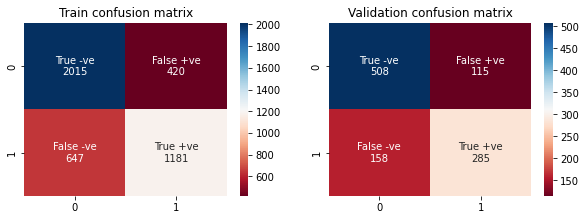

In [ ]:
#generating the confusion matrix
from sklearn.metrics import confusion_matrix
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(221)
cf_matr1=confusion_matrix(y_train,pred_clf_tr_)
plt.title('Train confusion matrix')
Heatmapgen(cf_matr1)
ax2 = fig.add_subplot(222)
cf_matr2=confusion_matrix(y_valid,pred_clf_val_)
plt.title('Validation confusion matrix')
Heatmapgen(cf_matr2)

In [ ]:
#storing the predictions in a list
pred_clf_val=[i[0] for i in pred_clf_val]
pred_clf_tr=[i[0] for i in pred_clf_tr]

In [ ]:
#getting the misclassified data points
wrng_pred=np.where(pred_clf_tr!=y_train,1,0)
#getting the indices..
wrng_pred=np.argwhere(wrng_pred)
wrng_pred=[i[0] for i in wrng_pred]
#out of misclassified datapoints randomly sampling 500 data points
smpl=random.sample(wrng_pred,500)
X_tr_smp=X_train.iloc[smpl]
y_tr_smp=y_train.iloc[smpl]
#oversampling the train set with misclassified datapoints
X_train_new=X_train.append(X_tr_smp)
y_train_new=y_train.append(y_tr_smp)

In [ ]:
im_height=128
im_width=128
tf.keras.backend.clear_session()
tr_cnn_generator = cnn_generator1(X_train_new,y_train_new, is_training=True, batch_size=64)
val_cnn_generator = cnn_generator1(X_valid,y_valid, is_training=False, batch_size=64)

In [ ]:
#retraining the model with oversampled data
result_clf=model_clf.fit(tr_cnn_generator,steps_per_epoch=64,epochs=20,validation_data=val_cnn_generator,validation_steps=64,callbacks=callbacks,initial_epoch=10)

Epoch 11/20
64/64 [==============================] - ETA: 0s - loss: 0.4687 - accuracy: 0.7537 - auc: 0.8494
Epoch 11: val_loss did not improve from 0.30878
64/64 [==============================] - 66s 941ms/step - loss: 0.4687 - accuracy: 0.7537 - auc: 0.8494 - val_loss: 0.4876 - val_accuracy: 0.7571 - val_auc: 0.8376
Epoch 12/20
64/64 [==============================] - ETA: 0s - loss: 0.4731 - accuracy: 0.7605 - auc: 0.8509
Epoch 12: val_loss did not improve from 0.30878
64/64 [==============================] - 66s 1s/step - loss: 0.4731 - accuracy: 0.7605 - auc: 0.8509 - val_loss: 0.4786 - val_accuracy: 0.7675 - val_auc: 0.8474
Epoch 13/20
64/64 [==============================] - ETA: 0s - loss: 0.4425 - accuracy: 0.7747 - auc: 0.8672
Epoch 13: val_loss did not improve from 0.30878
64/64 [==============================] - 54s 850ms/step - loss: 0.4425 - accuracy: 0.7747 - auc: 0.8672 - val_loss: 0.4809 - val_accuracy: 0.7710 - val_auc: 0.8513
Epoch 14/20
64/64 [=====================

In [ ]:
model.save('/content/drive/MyDrive/classifier_nerve')

In [ ]:
#getting predictions using new model
X_tr=np.zeros((len(X_train),128,128,4))
X_val=np.zeros((len(X_valid),128,128,4))
for i in range(len(X_train)):
  X_tr[i]=classifier_generator(X_train.iloc[i])
for i in range(len(X_valid)):
  X_val[i]=classifier_generator(X_valid.iloc[i])  
pred_clf_tr=model_clf.predict(X_tr)
pred_clf_val=model_clf.predict(X_val)

34/34 [==============================] - 2s 59ms/step


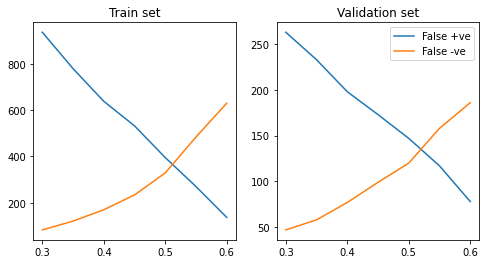

In [ ]:
#plotting the fp and fn in train and validation set
fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].set_title('Train set')
ax[0].plot(thresholds,fp_arr_tr,label='False +ve')
ax[0].plot(thresholds,fn_arr_tr,label='False -ve')
ax[1].set_title('Validation set')
ax[1].plot(thresholds,fp_arr_val,label='False +ve')
ax[1].plot(thresholds,fn_arr_val,label='False -ve')
plt.legend()
plt.show()

In [ ]:
#segmentator

In [ ]:
img=pd.read_csv('/content/dup_rem.csv')
df=pd.read_csv('/content/train_masks.csv')
img.drop('Unnamed: 0',axis=1,inplace=True)
img.image_name=img.image_name.astype(int)
img.subject_name=img.subject_name.astype(int)
img.columns=['image_path','img','subject','mask_path']
new_df=pd.merge(img,df,on=['img','subject'])
new_df.pixels.fillna(0,inplace=True)
val=[0 if i==0 else 1 for i in new_df.pixels]
new_df['mask_pres']=val

In [ ]:
pos_df=new_df[new_df.mask_pres==1]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(pos_df.image_path, pos_df.mask_path, test_size=0.2, random_state=42)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
im_height=128
im_width=128

In [ ]:
def atrous_block(input):
  '''Implement DAC block as given in paper'''
  q1=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr0',dilation_rate=1,activation='relu')(input)
  q2=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr1',dilation_rate=2,activation='relu')(input)
  q2=Conv2D(filters=512,kernel_size=(1,1),padding='same',strides=1,name='atr2',dilation_rate=1,activation='relu')(q2)
  q3=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr3',dilation_rate=1,activation='relu')(input)
  q3=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr4',dilation_rate=2,activation='relu')(q3)
  q3=Conv2D(filters=512,kernel_size=(1,1),padding='same',strides=1,name='atr5',dilation_rate=1,activation='relu')(q3)
  q4=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr6',dilation_rate=1,activation='relu')(input)
  q4=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr7',dilation_rate=2,activation='relu')(q4)
  q4=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr8',dilation_rate=4,activation='relu')(q4)
  q4=Conv2D(filters=512,kernel_size=(1,1),padding='same',strides=1,name='atr9',dilation_rate=1,activation='relu')(q4)
  atr_out=concatenate([q1,q2,q3,q4],axis=-1)
  print(atr_out.shape)
  return atr_out


In [ ]:
def rmp_block(input):
  '''Implement RMP block as given in paper'''
  X1=MaxPooling2D((2,2),strides=(2,2))(input)
  X1=Conv2DTranspose(512,(2,2),padding='same',activation='relu',strides=(2,2))(X1)
  X2=MaxPooling2D((3,3),strides=(2,2),padding='same')(input)
  X2=Conv2DTranspose(512,(3,3),padding='same',activation='relu',strides=(2,2))(X2)
  X3=MaxPooling2D((5,5),strides=(2,2),padding='same')(input)
  X3=Conv2DTranspose(512,(5,5),padding='same',activation='relu',strides=(2,2))(X3)
  X4=MaxPooling2D((6,6),strides=(2,2),padding='same')(input)
  X4=Conv2DTranspose(512,(6,6),padding='same',activation='relu',strides=(2,2))(X4)
  concat=concatenate([X1,X2,X3,X4],axis=-1)
  return concat


In [ ]:
def convolutional_block(input, filters=3, kernel_size=3, batchnorm = True):
    #conv layer followed by batchnormalization
    x = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same')(input)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same')(input)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    return x

In [ ]:
def resunet_opt(input_img, filters = 64, dropout = 0.2, batchnorm = True):
    """Residual Unet + Dense Atrous convolution + Rmp block"""
    conv1 = convolutional_block(input_img, filters * 1, kernel_size = 3, batchnorm = batchnorm)
    pool1 = MaxPooling2D((2, 2))(conv1)
    drop1 = Dropout(dropout)(pool1)

    conv2 = convolutional_block(drop1, filters * 2, kernel_size = 3, batchnorm = batchnorm)
    pool2 = MaxPooling2D((2, 2))(conv2)
    drop2 = Dropout(dropout)(pool2)

    conv3 = convolutional_block(drop2, filters * 4, kernel_size = 3, batchnorm = batchnorm)
    pool3 = MaxPooling2D((2, 2))(conv3)
    drop3 = Dropout(dropout)(pool3)

    conv4 = convolutional_block(drop3, filters * 8, kernel_size = 3, batchnorm = batchnorm)
    pool4 = MaxPooling2D((2, 2))(conv4)
    drop4 = Dropout(dropout)(pool4)

    conv5 = convolutional_block(drop4, filters = filters * 16, kernel_size = 3, batchnorm = batchnorm)
    #atrous conv or dillated conv is when filter has holes in it.
    conv5=atrous_block(conv5)
    conv5 = convolutional_block(conv5, filters = filters * 16, kernel_size = 3, batchnorm = batchnorm)
    conv5=rmp_block(conv5)
    conv5 = convolutional_block(conv5, filters = filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    ups6 = Conv2DTranspose(filters * 8, (3, 3), strides = (2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv5)
    ups6 = concatenate([ups6, conv4])
    ups6 = Dropout(dropout)(ups6)
    conv6 = convolutional_block(ups6, filters * 8, kernel_size = 3, batchnorm = batchnorm)

    ups7 = Conv2DTranspose(filters * 4, (3, 3), strides = (2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv6)
    ups7 = concatenate([ups7, conv3])
    ups7 = Dropout(dropout)(ups7)
    conv7 = convolutional_block(ups7, filters * 4, kernel_size = 3, batchnorm = batchnorm)

    ups8 = Conv2DTranspose(filters * 2, (3, 3), strides = (2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv7)
    ups8 = concatenate([ups8, conv2])
    ups8 = Dropout(dropout)(ups8)
    conv8 = convolutional_block(ups8, filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    ups9 = Conv2DTranspose(filters * 1, (3, 3), strides = (2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv8)
    ups9 = concatenate([ups9, conv1])
    ups9 = Dropout(dropout)(ups9)
    conv9 = convolutional_block(ups9, filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(4, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
def tfdata_generator(images, maskname, is_training, batch_size=64):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename,maskname):
        #reading path 
        image_string = tf.io.read_file(filename)
        #decoding image
        image = tfio.experimental.image.decode_tiff(image_string)

        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        
        image = tf.image.resize(image, [im_height, im_width])
        
        mask=tf.io.read_file(maskname)
        mask=tfio.experimental.image.decode_tiff(mask)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        mask = tf.image.resize(mask, [im_height, im_width],method='nearest')
        return image,mask
    
    def flip_lr(image,labels):
        
        image = tf.image.flip_left_right(image)
        labels = tf.image.flip_left_right(labels)
        
        return image,labels
    def flip_ud(image,labels):
        
        image = tf.image.flip_up_down(image)
        labels = tf.image.flip_up_down(image)
        
        return image,labels    
    
    def rotate(image,labels):
        val=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        return tf.image.rot90(image, val),tf.image.rot90(labels,val)
    
    
    dataset = tf.data.Dataset.from_tensor_slices((images,maskname))
    
    if is_training:
        dataset = dataset.shuffle(5000)  # depends on sample size
        
    # Transform and batch data at the same time
    dataset = dataset.apply(tf.data.experimental.map_and_batch( parse_function, batch_size,num_parallel_batches=4,  # cpu cores
        drop_remainder=True if is_training else False))
    # augmentations = [flip,rotate]
    
    if is_training:   
      if np.random.uniform(0,1)<0.2:
          dataset = dataset.map(flip_lr)
      elif np.random.uniform(0,1)<0.4:
          dataset = dataset.map(flip_ud)
      elif np.random.uniform(0,1)<0.5:        
          dataset = dataset.map(rotate)
    dataset = dataset.repeat()
    
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
tf.keras.backend.clear_session()
tr_image_generator = tfdata_generator(X_train,y_train, is_training=True, batch_size=64)
val_image_generator = tfdata_generator(X_valid,y_valid, is_training=False, batch_size=64)

In [ ]:
from datetime import datetime
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True,write_grads=True)
callbacks = [
    ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=False),
    tensorboard_callback]

In [ ]:
# im_height=128
# im_width=128
# input_img = Input((im_height, im_width,4), name='img')
# model = resunet_opt(input_img, filters=16, dropout=0.4, batchnorm=True)
model.compile(optimizer=Adam(lr=1e-5), loss=focal_loss, metrics=[iou_score])

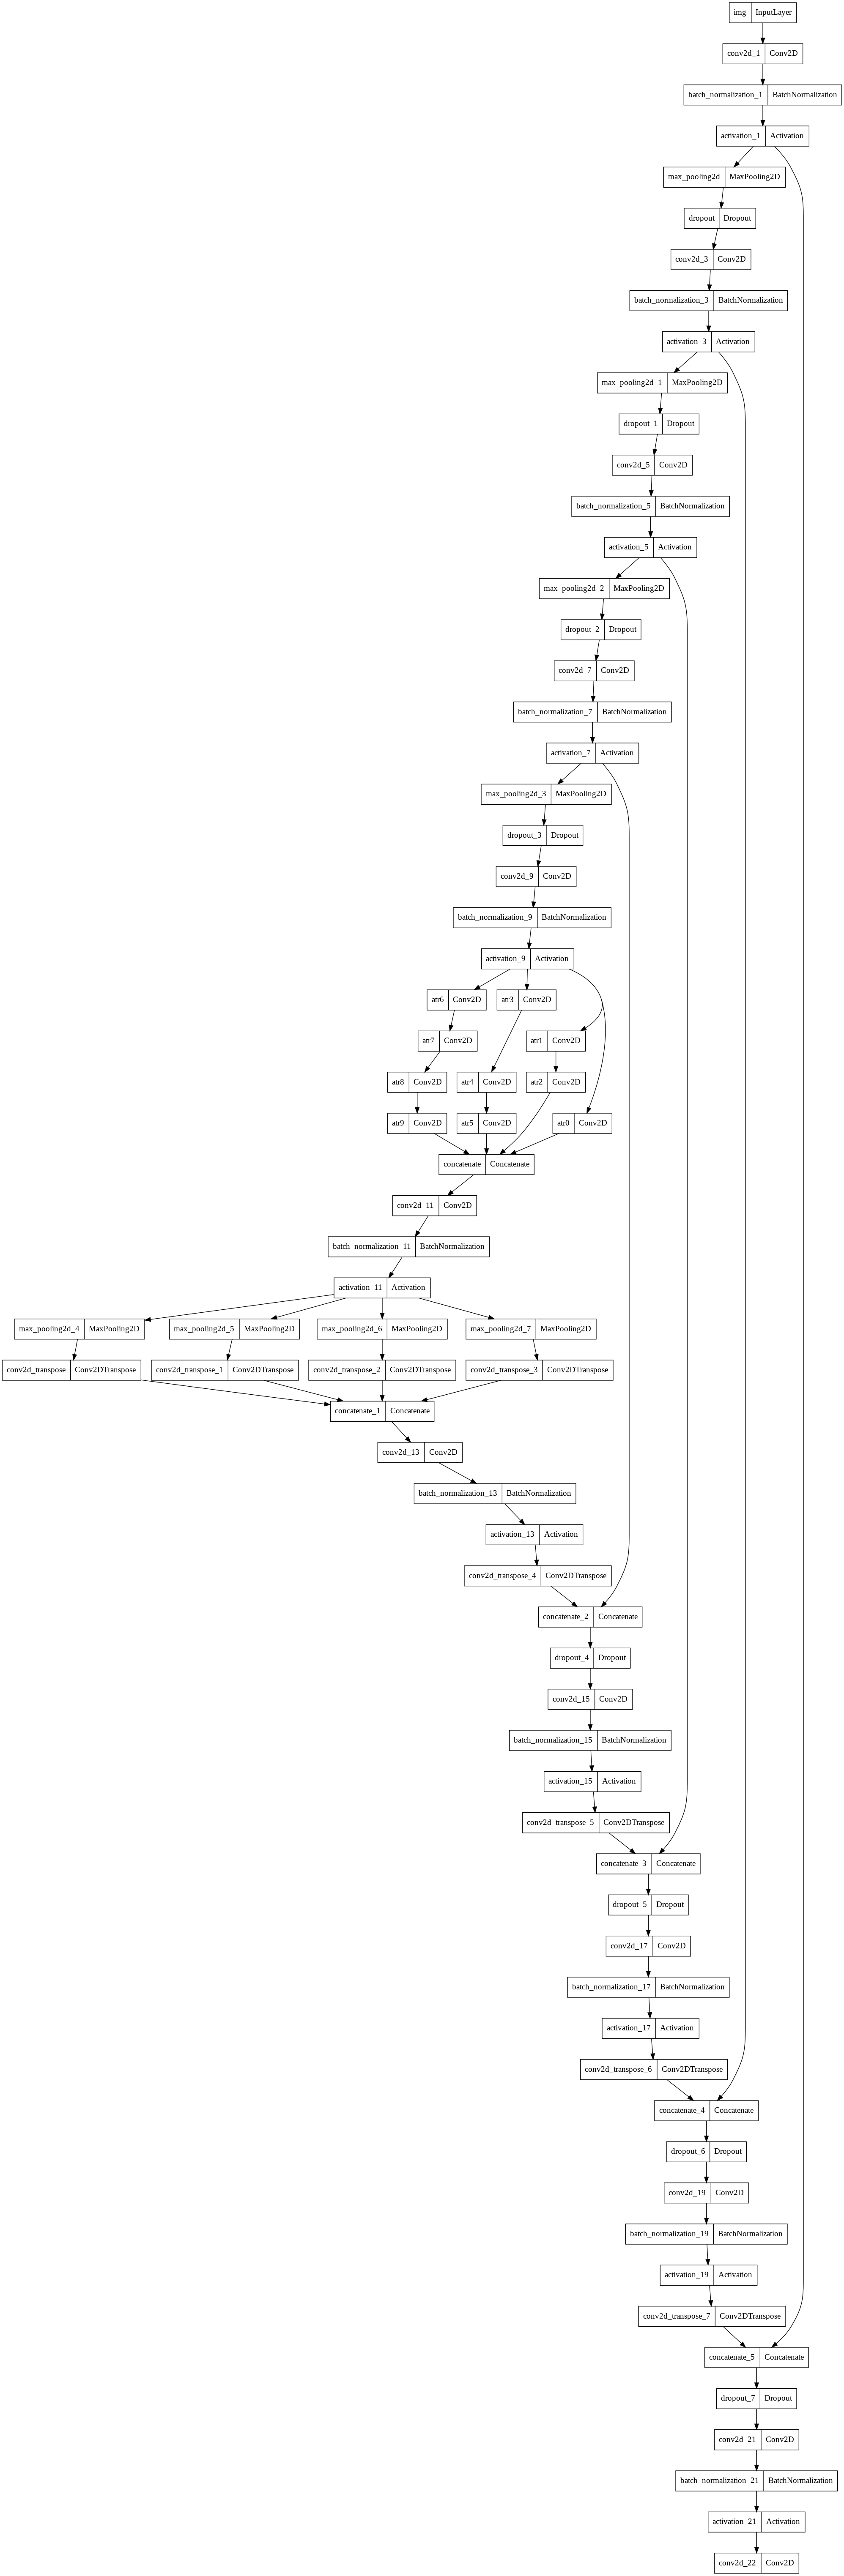

In [ ]:
plot_model(model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [ ]:
result=model.fit(tr_image_generator,steps_per_epoch=64,epochs=45,validation_data=val_image_generator,validation_steps=64,callbacks=callbacks,initial_epoch=35)

Epoch 36/45
64/64 [==============================] - ETA: 0s - loss: 0.2993 - iou_score: 0.6405
Epoch 36: val_loss improved from inf to 0.42640, saving model to best_model.h5
64/64 [==============================] - 100s 1s/step - loss: 0.2993 - iou_score: 0.6405 - val_loss: 0.4264 - val_iou_score: 0.5431
Epoch 37/45
64/64 [==============================] - ETA: 0s - loss: 0.2891 - iou_score: 0.6519
Epoch 37: val_loss improved from 0.42640 to 0.32375, saving model to best_model.h5
64/64 [==============================] - 63s 999ms/step - loss: 0.2891 - iou_score: 0.6519 - val_loss: 0.3237 - val_iou_score: 0.6300
Epoch 38/45
64/64 [==============================] - ETA: 0s - loss: 0.2822 - iou_score: 0.6596
Epoch 38: val_loss did not improve from 0.32375
64/64 [==============================] - 70s 1s/step - loss: 0.2822 - iou_score: 0.6596 - val_loss: 0.3638 - val_iou_score: 0.5978
Epoch 39/45
64/64 [==============================] - ETA: 0s - loss: 0.2763 - iou_score: 0.6660
Epoch 39:

In [ ]:
model.save('/content/drive/MyDrive/segmetnor')

In [ ]:
model.load_weights('best_model.h5')

In [ ]:
def classifier_generator(images):
    '''Construct a data generator using tf.Dataset to load only images'''
    image_string=tf.io.read_file(images)
    image = tfio.experimental.image.decode_tiff(image_string)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return image

In [ ]:
def train_generator(images,masks):
    '''Construct a data generator using tf.Dataset to load image+masks'''
    image_string=tf.io.read_file(images)
    image = tfio.experimental.image.decode_tiff(image_string)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    mask=tf.io.read_file(masks)
    mask = tfio.experimental.image.decode_tiff(mask)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [128, 128],method='nearest')
    return image,mask

In [ ]:
def iou_coef(y_true, y_pred, smooth=1):
  '''This function calculates iou '''
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
  union = K.sum(y_true,[1,2])+K.sum(y_pred,[1,2])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth))
  return iou.numpy()

In [ ]:
#loading image df
img=pd.read_csv('/content/dup_rem.csv')
df=pd.read_csv('/content/train_masks.csv')
img.drop('Unnamed: 0',axis=1,inplace=True)
img.image_name=img.image_name.astype(int)
img.subject_name=img.subject_name.astype(int)
img.columns=['image_path','img','subject','mask_path']
new_df=pd.merge(img,df,on=['img','subject'])
new_df.pixels.fillna(0,inplace=True)
val=[0 if i==0 else 1 for i in new_df.pixels]
new_df['mask_pres']=val
pos_df=new_df[new_df.mask_pres==1]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(new_df.image_path, new_df.mask_path, test_size=0.2, random_state=42)

In [ ]:
#loading the classifier model
model_clf = tf.keras.models.load_model('/content/drive/MyDrive/classifier_nerve',custom_objects={'categorical_crossentropy_plus_dice_loss':focal_loss,'iou_score':iou_score})
#model_clf.compile(optimizer=Adam(learning_rate=1e-5), loss=focal_loss, metrics=[iou_score])

In [ ]:
#loading the segmentor model
model=keras.models.load_model('/content/drive/MyDrive/segmetnor',custom_objects={'categorical_crossentropy_plus_dice_loss':focal_loss,'iou_score':iou_score})

In [ ]:
#quantizing classifier model
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/classifier_nerve')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quant_model_clf = converter.convert()
#quantizing segmentor model
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/segmetnor')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quant_model = converter.convert()

In [ ]:
#saving the tflite file of classifier quantized model
f = open("quant_classifier.tflite", "wb")
f.write(quant_model_clf)
f.close()
#saving the tflite file of segmentor quantized model
f = open("quant_segmentor.tflite", "wb")
f.write(quant_model)
f.close()

In [ ]:
interpreter_clf = tf.lite.Interpreter(model_path="quant_classifier.tflite")
interpreter_clf.allocate_tensors()
interpreter_seg = tf.lite.Interpreter(model_path="quant_segmentor.tflite",num_threads=1)
interpreter_seg.allocate_tensors()

In [ ]:
# test_image = tf.expand_dims(x_tes, axis=0)
# test_image=tf.cast(test_image,tf.float32)

input_index = interpreter_clf.get_input_details()[0]["index"]
output_index = interpreter_clf.get_output_details()[0]["index"]

# input_index = interpreter_seg.get_input_details()[0]["index"]
# output_index = interpreter_seg.get_output_details()[0]["index"]

# interpreter_seg.set_tensor(input_index, test_image)
# interpreter_seg.invoke()
# predictions = interpreter_seg.get_tensor(output_index)

In [ ]:
#Getting the prediction on validation set ofafter quantized model
scores_val=[]
X_tr=np.zeros((len(X_valid),128,128,4),dtype=np.float32)
y_tr=np.zeros((len(y_valid),128,128,4),dtype=np.float32)
pred_val=np.zeros((len(y_valid),128,128,4),dtype=np.float32)
for i in range(len(X_valid)):
  image_cl=classifier_generator(X_valid.iloc[i])
  image_cl=tf.expand_dims(image_cl,0)
  image_cl=tf.cast(image_cl,tf.float32)
  interpreter_clf.set_tensor(input_index, image_cl)
  interpreter_clf.invoke()
  pred_clf = interpreter_clf.get_tensor(output_index)
  if pred_clf.all()>=0.4:
    X_tr[i],y_tr[i]=train_generator(X_valid.iloc[i],y_valid.iloc[i])
    pred_seg=model.predict(tf.expand_dims(X_tr[i],0))
    pred_val[i]=pred_seg
    true=tf.expand_dims(y_tr[i],0)
    score=iou_coef(true,pred_seg)
    scores_val.append(score)
  else:
    X_tr[i],y_tr[i]=train_generator(X_valid.iloc[i],y_valid.iloc[i])
    pred_seg=np.zeros((1,128,128,4),dtype=np.float32)
    pred_val[i]=pred_seg
    true=tf.expand_dims(y_tr[i],0)
    score=iou_coef(true,pred_seg)
    scores_val.append(score)

In [ ]:
#Getting the prediction on validation set of before quantized model
scores_val_b=[]
X_tr=np.zeros((len(X_valid),128,128,4),dtype=np.float32)
y_tr=np.zeros((len(y_valid),128,128,4),dtype=np.float32)
pred_val_b=np.zeros((len(y_valid),128,128,4),dtype=np.float32)
for i in range(len(X_valid)):
  image_cl=classifier_generator(X_valid.iloc[i])
  image_cl=tf.expand_dims(image_cl,0)
  pred_clf=model_clf.predict(image_cl)
  if pred_clf>=0.4:
    X_tr[i],y_tr[i]=train_generator(X_valid.iloc[i],y_valid.iloc[i])
    pred_seg=model.predict(tf.expand_dims(X_tr[i],0))
    pred_val_b[i]=pred_seg
    true=tf.expand_dims(y_tr[i],0)
    score=iou_coef(true,pred_seg)
    scores_val_b.append(score)
  else:
    X_tr[i],y_tr[i]=train_generator(X_valid.iloc[i],y_valid.iloc[i])
    pred_seg=np.zeros((1,128,128,4),dtype=np.float32)
    pred_val_b[i]=pred_seg
    true=tf.expand_dims(y_tr[i],0)
    score=iou_coef(true,pred_seg)
    scores_val_b.append(score)